In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import gaussian_kde
from joblib import dump

In [2]:
class ResNetBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResNetBlock, self).__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, in_features, num_blocks, hidden_size):
        super(ResNet, self).__init__()
        self.fc_in = nn.Linear(in_features, hidden_size)
        self.relu = nn.ReLU()
        self.blocks = nn.Sequential(
            *[ResNetBlock(hidden_size) for _ in range(num_blocks)]
        )
        self.fc_out = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out = self.fc_in(x)
        out = self.relu(out)
        out = self.blocks(out)
        out = self.fc_out(out)
        return out


In [3]:
def load_partial_state_dict(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    new_state_dict = model.state_dict()

    for k in checkpoint:
        if k.startswith('blocks') or k.startswith('fc_out'):
            if k in new_state_dict and checkpoint[k].shape == new_state_dict[k].shape:
                new_state_dict[k] = checkpoint[k]
    model.load_state_dict(new_state_dict)
    return model


In [4]:
def finetune_for_setpoint_and_feature(
    set_point, feature_set_name, features, params,
    foundation_path, train_path, test_path, save_path,
    scaler_dir='./scalers'):
    import os
    os.makedirs(scaler_dir, exist_ok=True)
    
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)
    X_train = train_df[features]
    y_train = train_df.iloc[:, -1]
    X_test  = test_df[features]
    y_test  = test_df.iloc[:, -1]

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled  = scaler_X.transform(X_test)

    scaler_save_path = os.path.join(
        scaler_dir, f"scaler_{feature_set_name}_{set_point}.joblib"
    )
    dump(scaler_X, scaler_save_path)
    print(f"Scaler saved to: {scaler_save_path}")

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor  = torch.tensor(y_test.values, dtype=torch.float32)

    batch_size = params['batch_size']
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    input_size = len(features)
    num_blocks = params['num_blocks']
    hidden_size = params['hidden_size']
    model = ResNet(input_size, num_blocks, hidden_size)
    model = load_partial_state_dict(model, foundation_path)

    for param in model.parameters():
        param.requires_grad = False
    for param in model.fc_in.parameters():
        param.requires_grad = True
    for param in model.fc_out.parameters():
        param.requires_grad = True

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=params['learning_rate']
    )

    num_epochs = params['num_epochs']
    best_mse = float('inf')
    best_model = None

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.view(-1), y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        if epoch_loss < best_mse:
            best_mse = epoch_loss
            best_model = model.state_dict()
        print(f'[Setpoint={set_point}, {feature_set_name}] Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}')

    model.load_state_dict(best_model)
    torch.save(model.state_dict(), save_path)
    print(f"Saved model: {save_path}")

    return scaler_X  

In [ ]:
res = pd.read_csv('/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/finetune_feature_set_grid_results.csv')
best_param_df = res.sort_values(['set_point', 'R2'], ascending=[True, False]).groupby('set_point').head(1)
best_param_dict = {row['set_point']: {'batch_size': row['batch_size'], 'num_epochs': row['num_epochs']} 
                   for idx, row in best_param_df.iterrows()}
set_points = [0.1, 0.2, 0.4, 0.8, 1.0]

finetune_params = {
    0.1: {'hidden_size': 1024, 'num_blocks': 10, 'learning_rate': 0.0001,  'num_frozen_blocks': 7},
    0.2: {'hidden_size': 1024, 'num_blocks': 19, 'learning_rate': 0.0001,  'num_frozen_blocks': 15},
    0.4: {'hidden_size': 1024, 'num_blocks': 13, 'learning_rate': 0.0001,  'num_frozen_blocks': 12},
    0.8: {'hidden_size': 1024, 'num_blocks': 20, 'learning_rate': 0.0001, 'num_frozen_blocks': 18},
    1.0: {'hidden_size': 1024, 'num_blocks': 11, 'learning_rate': 0.0001,  'num_frozen_blocks': 9}
}

for sp in set_points:
    params = finetune_params[sp]
    params['batch_size'] = int(best_param_dict[sp]['batch_size'])
    params['num_epochs'] = int(best_param_dict[sp]['num_epochs'])

(pd.DataFrame(finetune_params)).T

,hidden_size,num_blocks,learning_rate,num_frozen_blocks,batch_size,num_epochs
0.1,1024.0,10.0,0.0001,7.0,8.0,50.0
0.2,1024.0,19.0,0.0001,15.0,8.0,40.0
0.4,1024.0,13.0,0.0001,12.0,8.0,40.0
0.8,1024.0,20.0,0.0001,18.0,8.0,40.0
1.0,1024.0,11.0,0.0001,9.0,8.0,40.0


In [5]:
# finetune_params = {
#     0.1: {'batch_size': 8, 'hidden_size': 1024, 'num_blocks': 10, 'learning_rate': 0.0001, 'num_epochs': 30},
#     0.2: {'batch_size': 8, 'hidden_size': 1024, 'num_blocks': 19, 'learning_rate': 0.0001, 'num_epochs': 30},
#     0.4: {'batch_size': 8, 'hidden_size': 1024, 'num_blocks': 13, 'learning_rate': 0.0001, 'num_epochs': 30},
#     0.8: {'batch_size': 8, 'hidden_size': 1024, 'num_blocks': 20, 'learning_rate': 0.0001, 'num_epochs': 30},
#     1.0: {'batch_size': 8, 'hidden_size': 1024, 'num_blocks': 11, 'learning_rate': 0.0001, 'num_epochs': 30}
# }

In [6]:
foundation_model_dir = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/'
save_model_dir = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/'
data_dir = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/data/'

feature_sets = {
    # 'Drop_ACSM': ['Temperature', 'RH', 'Bulk_DP', 'Num_Conc'],
    # 'Drop_SD':   ['Temperature', 'RH', 'OA', 'SO4', 'Cl', 'NH4', 'NO3'],
    # 'Drop_MET':  ['Bulk_DP', 'Num_Conc', 'OA', 'SO4', 'Cl', 'NH4', 'NO3']
    'Drop_N_':      ['Temperature', 'RH', 'Bulk_DP', 'Num_Conc', 'OA', 'SO4', 'Cl']
}

In [7]:
scaler_dir = os.path.join(save_model_dir, "scaler")  # 推荐在模型目录下新建scaler文件夹
os.makedirs(scaler_dir, exist_ok=True)

for set_point in set_points:
    foundation_path = os.path.join(foundation_model_dir, f'Foundation_Model_{set_point}.pth')
    train_path = os.path.join(data_dir, f'setpoint_{set_point}_train.csv')
    test_path  = os.path.join(data_dir, f'setpoint_{set_point}_test.csv')
    params = finetune_params[set_point]

    for feature_set_name, features in feature_sets.items():
        save_path = os.path.join(
            save_model_dir,
            f'best_resnet_finetuned_{set_point}_{feature_set_name}.pth'
        )
        print(f"\n=== Training set_point={set_point}, feature_set={feature_set_name} ===")
        finetune_for_setpoint_and_feature(
            set_point, feature_set_name, features, params,
            foundation_path, train_path, test_path, save_path,
            scaler_dir=scaler_dir           # <--- 一定要加
        )


=== Training set_point=0.1, feature_set=Drop_N ===
Scaler saved to: /data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/scaler/scaler_Drop_N_0.1.joblib
[Setpoint=0.1, Drop_N] Epoch 1/50, Train Loss: 34230.9978
[Setpoint=0.1, Drop_N] Epoch 2/50, Train Loss: 24677.6423
[Setpoint=0.1, Drop_N] Epoch 3/50, Train Loss: 17726.4016
[Setpoint=0.1, Drop_N] Epoch 4/50, Train Loss: 14207.0877
[Setpoint=0.1, Drop_N] Epoch 5/50, Train Loss: 12292.2160
[Setpoint=0.1, Drop_N] Epoch 6/50, Train Loss: 11155.7229
[Setpoint=0.1, Drop_N] Epoch 7/50, Train Loss: 10268.3140
[Setpoint=0.1, Drop_N] Epoch 8/50, Train Loss: 9566.0094
[Setpoint=0.1, Drop_N] Epoch 9/50, Train Loss: 8938.9273
[Setpoint=0.1, Drop_N] Epoch 10/50, Train Loss: 8409.3550
[Setpoint=0.1, Drop_N] Epoch 11/50, Train Loss: 7843.5462
[Setpoint=0.1, Drop_N] Epoch 12/50, Train Loss: 7482.6991
[Setpoint=0.1, Drop_N] Epoch 13/50, Train Loss: 7222.8980
[Setpoint=0.1, Drop_N] Epoch 14/50, Train Loss: 6929.6006
[Setpoint=0.1, Drop_N] Epoch 


==== Evaluating feature set: Drop_N ====

>>> 处理 set_point = 0.1


/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  MSE = 5418.2788, RMSE = 73.6090, R² = 0.6905, MAPE = 40.2%

>>> 处理 set_point = 0.2


/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  MSE = 26800.6446, RMSE = 163.7090, R² = 0.7891, MAPE = 30.1%

>>> 处理 set_point = 0.4


/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  MSE = 70861.7822, RMSE = 266.1988, R² = 0.7932, MAPE = 28.3%

>>> 处理 set_point = 0.8


/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  MSE = 113261.6560, RMSE = 336.5437, R² = 0.8370, MAPE = 29.5%

>>> 处理 set_point = 1.0


/data/keeling/a/xx24/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/tmp/ipykernel_94206/1371524500.py:140: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.88, 1])


  MSE = 283662.6727, RMSE = 532.5999, R² = 0.7176, MAPE = 36.4%


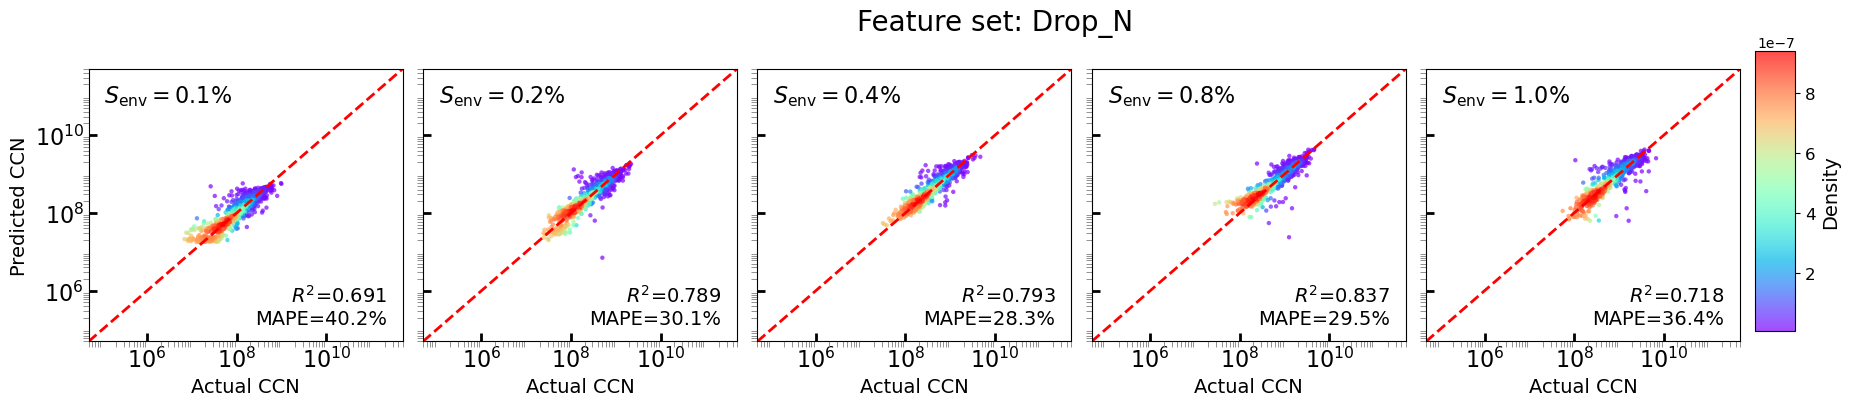

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 假设已定义好ResNet, ResNetBlock, set_points, finetune_params, feature_sets, 等
# 文件路径前缀
model_dir = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/model/'
data_dir = '/data/keeling/a/xx24/e/proj_ml/code_ml_surfactant_ccn/data/'

from joblib import load

for feature_set_name, features in feature_sets.items():
    print(f"\n==== Evaluating feature set: {feature_set_name} ====")
    xmin, xmax = 5e4, 5e11
    ymin, ymax = 5e4, 5e11

    fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)
    scatter_list = []

    for i, sp in enumerate(set_points):
        ax = axes[i]
        print(f"\n>>> 处理 set_point = {sp}")

        # ========== 模型加载 ==========
        num_blocks  = finetune_params[sp]['num_blocks']
        hidden_size = finetune_params[sp]['hidden_size']
        in_features = len(features)
        model = ResNet(in_features, num_blocks, hidden_size).to(device)
        model_path = os.path.join(model_dir, f'best_resnet_finetuned_{sp}_{feature_set_name}.pth')
        if not os.path.isfile(model_path):
            print(f"模型文件 {model_path} 不存在，跳过 {sp}")
            continue

        state_dict = torch.load(model_path, map_location=device)
        model.load_state_dict(state_dict)
        model.eval()

        # ========== 测试数据加载 & 标准化 ==========
        test_csv = os.path.join(data_dir, f'setpoint_{sp}_test.csv')
        train_csv = os.path.join(data_dir, f'setpoint_{sp}_train.csv')  # 用train做scaler
        if not os.path.isfile(test_csv):
            print(f"测试集文件 {test_csv} 不存在，跳过 {sp}")
            continue
        if not os.path.isfile(train_csv):
            print(f"训练集文件 {train_csv} 不存在，跳过 {sp}")
            continue

        arm_test_data = pd.read_csv(test_csv)
        arm_train_data = pd.read_csv(train_csv)
        X_arm_test = arm_test_data[features].values
        y_arm_test = arm_test_data.iloc[:, -1].values  # 假设N_CCN是最后一列
        X_arm_train = arm_train_data[features].values

        # 标准化用train的scaler（防止泄露）
# ========== 标准化加载 ==========
        scaler_path = os.path.join(
            scaler_dir, f"scaler_{feature_set_name}_{sp}.joblib"
        )
        if not os.path.isfile(scaler_path):
            print(f"scaler文件 {scaler_path} 不存在，跳过 {sp}")
            continue
        scaler_X = load(scaler_path)

        X_arm_test_scaled = scaler_X.transform(X_arm_test)
        X_test_tensor = torch.tensor(X_arm_test_scaled, dtype=torch.float32).to(device)

        # ========== 预测 ==========
        with torch.no_grad():
            preds_tensor = model(X_test_tensor).view(-1)
            y_pred = preds_tensor.cpu().numpy()

        # ========== 评估指标 ==========
        mse  = np.mean((y_pred - y_arm_test) ** 2)
        rmse = np.sqrt(mse)
        ss_res = np.sum((y_arm_test - y_pred) ** 2)
        ss_tot = np.sum((y_arm_test - np.mean(y_arm_test)) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else float('nan')
        mape = np.mean(np.abs((y_pred - y_arm_test) / y_arm_test)) * 100

        print(f"  MSE = {mse:.4f}, RMSE = {rmse:.4f}, R² = {r2:.4f}, MAPE = {mape:.1f}%")

        # ========== 绘图 ==========
        xy = np.vstack([y_arm_test, y_pred])
        z = gaussian_kde(xy)(xy)

        sc = ax.scatter(
            y_arm_test*1e6, 
            y_pred*1e6, 
            c=z, 
            s=10, 
            cmap='rainbow',
            marker='o',
            linewidths=0,
            alpha=0.7
        )
        scatter_list.append(sc)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ticks = [1e6, 1e8, 1e10]
        labels = [r'$10^6$', r'$10^8$', r'$10^{10}$']
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels)
        ax.set_yticks(ticks)
        ax.set_yticklabels(labels)
        ax.xaxis.set_minor_locator(mtick.LogLocator(base=10, subs=np.arange(2, 10), numticks=100))
        ax.yaxis.set_minor_locator(mtick.LogLocator(base=10, subs=np.arange(2, 10), numticks=100))
        ax.tick_params(axis='x', which='minor', length=4, color='gray')
        ax.tick_params(axis='y', which='minor', length=4, color='gray')
        ax.plot([xmin, xmax], [xmin, xmax], 'r--', linewidth=2)
        ax.text(
            0.05, 0.95,
            f'$S_{{\\mathrm{{env}}}}={sp}\\%$',
            transform=ax.transAxes,
            fontsize=16,
            verticalalignment='top'
        )
        ax.text(
            0.95, 0.05,
            f'$R^2$={r2:.3f}\nMAPE={mape:.1f}%',
            transform=ax.transAxes,
            fontsize=14,
            verticalalignment='bottom',
            horizontalalignment='right'
        )
        ax.set_xlabel('Actual CCN', fontsize=14)
        if i == 0:
            ax.set_ylabel('Predicted CCN', fontsize=14)
        ax.tick_params(axis='both', which='major', direction='in', length=6, width=2, colors='black',
                        grid_color='gray', grid_alpha=0.7, labelsize=16)

    # ====== colorbar & 排版 ======
    fig.subplots_adjust(right=0.88)
    cbar_ax = fig.add_axes([0.88, 0.20, 0.02, 0.7])
    cbar = fig.colorbar(scatter_list[-1], cax=cbar_ax)
    cbar.set_label('Density', fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    plt.suptitle(f"Feature set: {feature_set_name}", fontsize=20, y=1.005)
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()